In [1]:
import pandas as pd
import re
import nltk
import numpy as np
nltk.download('stopwords')
from gensim.models import FastText
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# IMPORT DATA

Dataset : https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification

In [2]:
df_train = pd.read_csv('Corona_NLP_test.csv', encoding = "ISO-8859-1")

In [3]:
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
df_train = df_train[['OriginalTweet', 'Sentiment']]

In [5]:
df_train = df_train.rename(columns={
    'OriginalTweet' : 'tweet',
    'Sentiment' : 'sentiment'
})

In [6]:
df_train.head()

,tweet,sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


# EKSPLORASI DATA

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      41157 non-null  object
 1   sentiment  41157 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


In [8]:
df_train['sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: sentiment, dtype: int64

# PRE-PROCESSING DATA

In [9]:
df_train = df_train[df_train['sentiment'] != 'Neutral']
df_train.head()

,tweet,sentiment
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
5,As news of the regionÂs first confirmed COVID...,Positive


In [10]:
df_train['sentiment'].value_counts()

Positive              11422
Negative               9917
Extremely Positive     6624
Extremely Negative     5481
Name: sentiment, dtype: int64

In [11]:
labels_train = []
for label in df_train['sentiment']:
  if label == 'Extremely Negative':
    labels_train.append(0)
  elif label == 'Negative':
    labels_train.append(0)
  elif label == 'Positive':
    labels_train.append(1)
  elif label == 'Extremely Positive':
    labels_train.append(1)

In [12]:
df_train['sentiment'] = labels_train

In [13]:
df_train['sentiment'].value_counts()

1    18046
0    15398
Name: sentiment, dtype: int64

In [14]:
def clean_text(text):
  text = text.lower() # lower all sentence
  text = text.strip() # remove newline
  text = re.sub(r'(@[A-Za-z0–9_]+)|[^\w\s]|#|http\S+', "", text) # remove punctuation dan link
  stop_words = nltk.corpus.stopwords.words('english')
  text = ' '.join([word for word in text.split() if word not in stop_words]) # remove stopwords 
  return text

In [15]:
df_train['tweet'] = df_train['tweet'].apply(clean_text)

In [16]:
df_train.head()

,tweet,sentiment
1,advice talk neighbours family exchange phone n...,1
2,coronavirus australia woolworths give elderly ...,1
3,food stock one empty please dont panic enough ...,1
4,ready go supermarket covid19 outbreak im paran...,0
5,news regionâs first confirmed covid19 case cam...,1


In [17]:
X_train = df_train['tweet'].values
y_train = to_categorical(np.asarray(df_train['sentiment'].values))
# y_train = np.asarray(df_train['sentiment'].values)

In [18]:
X_train[0]

'advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order'

In [19]:
y_train[:5]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

# WORD EMBEDDING

Documentation FastText : https://radimrehurek.com/gensim/models/fasttext.html

In [20]:
tokenizer = nltk.WordPunctTokenizer()
CORPUS = [tokenizer.tokenize(text) for text in df_train['tweet']]
print(CORPUS[:2])

[['advice', 'talk', 'neighbours', 'family', 'exchange', 'phone', 'numbers', 'create', 'contact', 'list', 'phone', 'numbers', 'neighbours', 'schools', 'employer', 'chemist', 'gp', 'set', 'online', 'shopping', 'accounts', 'poss', 'adequate', 'supplies', 'regular', 'meds', 'order'], ['coronavirus', 'australia', 'woolworths', 'give', 'elderly', 'disabled', 'dedicated', 'shopping', 'hours', 'amid', 'covid19', 'outbreak']]


In [21]:
EMBEDDING_SIZE = 300
WINDOW_SIZE = 5
MIN_WORD = 5 # Model mengabaikan semua kata dengan frekuensi total lebih rendah dari ini.
ft_model = FastText(CORPUS, size=EMBEDDING_SIZE, window=WINDOW_SIZE, min_count=MIN_WORD)

In [22]:
FILEPATH_FT = "/content/drive/MyDrive/MSIB BISA AI/Klasifikasi Teks dengan LSTM dan FastText/ft.model"

ft_model.save(FILEPATH_FT)

In [23]:
ft_model.wv.most_similar('cvid19')

[('codvid19', 0.9059326648712158),
 ('convid19', 0.863893985748291),
 ('corvid19', 0.8539787530899048),
 ('canadacovid19', 0.8003771305084229),
 ('precovid19', 0.7937887907028198),
 ('highriskcovid19', 0.7734731435775757),
 ('postcovid19', 0.7651821374893188),
 ('âcovid19', 0.7646999359130859),
 ('coronavirusrelated', 0.7319769859313965),
 ('fightcovid19', 0.709640622138977)]

In [24]:
ft_model.wv['cvid19']

array([ 0.21591021,  0.20808291, -0.15668418, -0.08052132,  0.0309299 ,
        0.3267392 ,  0.18467367,  0.06557765, -0.3526076 , -0.22422086,
        0.08988742, -0.11930013,  0.06546101, -0.06646492,  0.16739243,
        0.5382016 , -0.01410911, -0.1475001 ,  0.04007573, -0.04792884,
       -0.09788597,  0.35956204,  0.16498004,  0.17130095, -0.38244566,
        0.20366786,  0.2538443 , -0.3639553 ,  0.5113261 ,  0.09219033,
        0.10099202, -0.16678248,  0.13195285,  0.13097046,  0.0054139 ,
       -0.0022596 , -0.49652246, -0.2491957 , -0.17830954, -0.19849263,
        0.16481976,  0.13758278, -0.27981406, -0.40104017,  0.07399821,
       -0.37119797, -0.40749124,  0.130178  , -0.0650908 , -0.32448182,
       -0.2153702 ,  0.4080343 , -0.10246143, -0.5672185 ,  0.3536949 ,
       -0.39931345, -0.20240551,  0.15597586,  0.20055354, -0.16504283,
        0.08257205,  0.28335196, -0.25296733, -0.46653387,  0.6054348 ,
       -0.08122829, -0.07429265, -0.20051748,  0.450624  ,  0.67

In [25]:
def tokenize(data):
    tokenized = [tokenizer.tokenize(text) for text in data]
    return tokenized

In [26]:
def vectorize(tokenized_data):
    vectorized = []
    failed_vectorized = []
    for text in tokenized_data:
        text_vec = []
        for word in text:
            try:
              text_vec.append(ft_model.wv[word])
            except:
              failed_vectorized.append(word)
        vectorized.append(text_vec)
    print('Word failed to vectorize :', failed_vectorized)
    return vectorized

In [27]:
def padding(vec, max_len):
    padded = []
    for text in vec:
        padded.append(text + [np.zeros(EMBEDDING_SIZE)] * (max_len - len(text)))
    return padded

In [28]:
X_train_tokenized = tokenize(X_train)

In [29]:
print(X_train_tokenized[0])

['advice', 'talk', 'neighbours', 'family', 'exchange', 'phone', 'numbers', 'create', 'contact', 'list', 'phone', 'numbers', 'neighbours', 'schools', 'employer', 'chemist', 'gp', 'set', 'online', 'shopping', 'accounts', 'poss', 'adequate', 'supplies', 'regular', 'meds', 'order']


In [30]:
X_train_vectorized = vectorize(X_train_tokenized)

Word failed to vectorize : ['wãrgl', 'â8', 'ktvu', 'b8', 'b9', 'bmj', 'x2', 'ezj', 'hk', 'lrw', '96', 'yqr', '3k', 'aj', 'fsr', 'q6', 'fn', 'pdf', 'jk', 'pdf', 'jk', 'hk', 'jr', 'vzw', 'qb', 'zm', 'ujo', '4h', 'lg', '3lv', 'hc', 'hw', 'jc', 'hw', 'z', 'hk', '7k', 'bf', 'p1', 'y11s', 'xbr', 'xbr', '7k', '6k', '6k', 'lgbtq', 'rmb790t', 'lhm', 'ktvu', 'wyt', 'wyt', 'nm', '3â', 'â8', 'hsr', '5b', 'â8', 'p1', 'â8', '3l', '3h', 'qsr', 'ifmk', '3n', 'sx3', 'hk', 'mâ', 'bâ', 'gnp', 'nfd', 'gvn', 'lwc', 'lwc', 'zu', 'qt', 'm6', 'x1', '7u7', 'hbu', '4m', '4mâ²', 'nfm', '7k', 'hq', 'g04', 'bmj', '82', 'xd', '2u', 'lwc', 'hbu', '1x', '4k', 'hbu', 'gbâ', 'sxxxl', 'gvmc', 'zuku', 'jm', 'uc', 'dq', '4x', 'rm5', 'nw', '4k', '6e', 'pkw', '5l', 'iq', 's3', 'yb', '4r', 'qsr', 'qsr', 'iq', '8k', 'hq', '1â', 'qoq', 'bmj', '4x', 'aj', 'wdn', 'wdn', 'pk', '1t', 'mhc', '2a', 'r8', 'm8', '1x', 'dlc', 'p3', 'f4f', '4l', '9r', 'e1', '1jn', '0rqâ', 'e1', 'e1', 'uyu', '04', 'tk', 'qr', '2a', 'yk', 'pdf', 'pwc', 'c

In [31]:
print(X_train_vectorized[0])

[array([ 6.79361999e-01,  4.68768254e-02, -3.91998529e-01,  3.97844881e-01,
       -4.25262362e-01, -2.75965124e-01,  8.55919123e-02,  5.01368344e-01,
       -1.85361028e-01,  1.62881836e-01,  8.17043185e-02,  1.41986668e-01,
       -1.84321240e-01,  2.72942156e-01, -1.93803668e-01,  1.62736010e-02,
        6.02226965e-02, -1.24854513e-01, -2.85870641e-01,  5.78013062e-01,
       -9.11208466e-02,  1.21445365e-01,  9.19234902e-02,  1.17094956e-01,
        1.30069166e-01,  6.51018918e-01, -1.88658357e-01, -3.28438997e-01,
        3.51660162e-01, -5.04532397e-01,  2.13385552e-01, -1.58375174e-01,
        4.05439921e-02,  4.90725599e-02,  3.79732072e-01, -2.00961664e-01,
       -4.43879187e-01,  6.90581575e-02, -1.10512316e-01,  5.35371006e-02,
        1.71369940e-01,  5.95744774e-02, -1.68643177e-01, -4.24467981e-01,
        2.83371538e-01,  2.12795511e-01,  1.07446529e-01,  9.62218195e-02,
       -3.58028412e-01, -6.70351759e-02,  2.14892160e-02, -7.56915808e-02,
       -7.10547641e-02, 

In [32]:
MAX_SEQUENCE_LENGTH = max([len(x) for x in X_train_vectorized])
print(MAX_SEQUENCE_LENGTH)

44


In [33]:
def padding_sequence(sequence, max_len):
    padded = []
    for text in sequence:
        padded.append(text + [np.zeros(EMBEDDING_SIZE)] * (max_len - len(text)))
    return padded

In [34]:
X_train_padded = padding_sequence(X_train_vectorized, max_len=MAX_SEQUENCE_LENGTH)

In [35]:
print('Sebelum padding :', np.shape(X_train_vectorized[0]))
print('Setelah padding :', np.shape(X_train_padded[0]))

Sebelum padding : (27, 300)
Setelah padding : (44, 300)


In [36]:
X_train = np.array(X_train_padded)

y_train = np.array(y_train)

In [37]:
X_train[0]

array([[ 6.79361999e-01,  4.68768254e-02, -3.91998529e-01, ...,
         8.12696293e-02,  1.78719297e-01, -2.30084524e-01],
       [ 1.06473848e-01,  3.79809029e-02,  1.41073048e-01, ...,
         2.85008639e-01,  1.61703527e-01, -1.90300405e-01],
       [ 1.73043013e-01,  2.27261782e-02,  6.14935358e-04, ...,
         8.27452317e-02, -8.77317786e-02, -3.42087060e-01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [38]:
y_train[0]

array([0., 1.], dtype=float32)

# Training LSTM

Documentation LSTM : https://keras.io/api/layers/recurrent_layers/lstm/

In [39]:
UNITS = 200

model = Sequential()
model.add(LSTM(UNITS, input_shape = (MAX_SEQUENCE_LENGTH, EMBEDDING_SIZE), dropout=0.2))
model.add(Dense(2, activation='softmax'))

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               400800    
                                                                 
 dense (Dense)               (None, 2)                 402       
                                                                 
Total params: 401,202
Trainable params: 401,202
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [42]:
FILEPATH_LSTM = '/content/drive/MyDrive/MSIB BISA AI/Klasifikasi Teks dengan LSTM dan FastText/best_model.h5'

checkpoint = ModelCheckpoint(FILEPATH_LSTM, monitor='val_accuracy',mode='max', save_best_only=True, verbose=1)

CALLBACKS_LIST = [checkpoint]

In [43]:
EPOCHS = 10
VAL_SPLIT = 0.2

history = model.fit(X_train, y_train, epochs=EPOCHS, verbose=1, validation_split=VAL_SPLIT, callbacks=CALLBACKS_LIST)

Epoch 1/10
831/837 [============================>.] - ETA: 0s - loss: 0.6300 - accuracy: 0.6421
Epoch 1: val_accuracy improved from -inf to 0.68814, saving model to /content/drive/MyDrive/MSIB BISA AI/Klasifikasi Teks dengan LSTM dan FastText/best_model.h5
837/837 [==============================] - 13s 9ms/step - loss: 0.6296 - accuracy: 0.6424 - val_loss: 0.5829 - val_accuracy: 0.6881
Epoch 2/10
834/837 [============================>.] - ETA: 0s - loss: 0.5819 - accuracy: 0.6875
Epoch 2: val_accuracy improved from 0.68814 to 0.70863, saving model to /content/drive/MyDrive/MSIB BISA AI/Klasifikasi Teks dengan LSTM dan FastText/best_model.h5
837/837 [==============================] - 7s 8ms/step - loss: 0.5820 - accuracy: 0.6874 - val_loss: 0.5603 - val_accuracy: 0.7086
Epoch 3/10
830/837 [============================>.] - ETA: 0s - loss: 0.5523 - accuracy: 0.7131
Epoch 3: val_accuracy improved from 0.70863 to 0.72417, saving model to /content/drive/MyDrive/MSIB BISA AI/Klasifikasi Teks

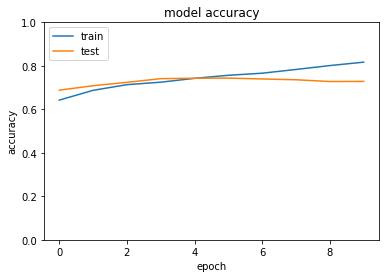

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0, 1)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

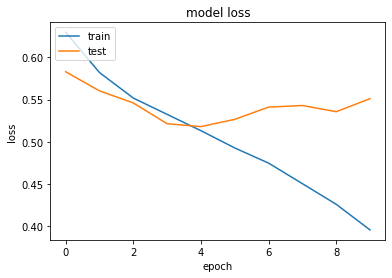

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# TEST MODEL

## DATA TEST PREPARATION

In [46]:
df_test = pd.read_csv('Corona_NLP_test.csv', encoding = "ISO-8859-1")

In [47]:
df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [48]:
df_test = df_test[['OriginalTweet', 'Sentiment']]

In [49]:
df_test = df_test.rename(columns={
    'OriginalTweet' : 'tweet',
    'Sentiment' : 'sentiment'
})

In [50]:
df_test.head()

,tweet,sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [51]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      3798 non-null   object
 1   sentiment  3798 non-null   object
dtypes: object(2)
memory usage: 59.5+ KB


In [52]:
df_test['sentiment'].value_counts()

Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: sentiment, dtype: int64

In [53]:
df_test = df_test[df_test['sentiment'] != 'Neutral']
df_test.head()

,tweet,sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
6,Voting in the age of #coronavirus = hand sanit...,Positive


In [54]:
df_test['sentiment'].value_counts()

Negative              1041
Positive               947
Extremely Positive     599
Extremely Negative     592
Name: sentiment, dtype: int64

In [55]:
labels_test = []
for label in df_test['sentiment']:
  if label == 'Extremely Negative':
    labels_test.append(0)
  elif label == 'Negative':
    labels_test.append(0)
  elif label == 'Positive':
    labels_test.append(1)
  elif label == 'Extremely Positive':
    labels_test.append(1)

In [56]:
df_test['sentiment'] = labels_test

In [57]:
df_test['tweet'] = df_test['tweet'].apply(clean_text)

In [58]:
df_test.head()

,tweet,sentiment
0,trending new yorkers encounter empty supermark...,0
1,couldnt find hand sanitizer fred meyer turned ...,1
2,find protect loved ones coronavirus,1
3,panic buying hits newyork city anxious shopper...,0
6,voting age coronavirus hand sanitizer supertue...,1


In [59]:
X_test = df_test['tweet'].values
y_test = to_categorical(np.asarray(df_test['sentiment'].values))
# y_test = np.asarray(df_test['sentiment'].values)

In [60]:
X_test[0]

'trending new yorkers encounter empty supermarket shelves pictured wegmans brooklyn soldout online grocers foodkick maxdelivery coronavirusfearing shoppers stock'

In [61]:
y_test[:5]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [62]:
X_test_tokenized = tokenize(X_test)

In [63]:
print(X_test_tokenized[0])

['trending', 'new', 'yorkers', 'encounter', 'empty', 'supermarket', 'shelves', 'pictured', 'wegmans', 'brooklyn', 'soldout', 'online', 'grocers', 'foodkick', 'maxdelivery', 'coronavirusfearing', 'shoppers', 'stock']


In [64]:
ft_model = FastText.load("ft.model")

In [65]:
X_test_vectorized = vectorize(X_test_tokenized)

Word failed to vectorize : ['qqq', 'nq', 'ui', 'f2f', 'xt4', 'e3', 'mgr', '3h', 'vãa', 'qqq', 'iwm', 'xd', 'kprc2', 'â8', '1a', 'z', '2a', 'â¾', 'jk', 'qr', 'g6', 'y3n', 'xyz', 'nm', '3n', 'z', 'yzf', 'd3', '07', 'lgbtq', 'zsl', 'p5', 'z', '9p', 'qtr', 'yqr', 'ktvu', 'yh']


In [66]:
print(X_test_vectorized[0])

[array([ 5.88284135e-01,  4.07852083e-02,  1.20262370e-01,  3.33531886e-01,
        1.12300269e-01, -4.09811288e-01, -9.43275914e-03,  2.14639097e-01,
       -2.36684591e-01,  5.60139865e-02,  1.18458651e-01, -8.08529258e-02,
       -7.08357215e-01, -2.54957497e-01, -4.86849785e-01,  3.55902836e-02,
       -2.58189857e-01, -6.59776060e-03, -3.32030654e-01,  5.49799204e-01,
       -4.73505050e-01, -2.55337507e-01,  1.52615055e-01,  7.73362815e-01,
        9.46403667e-02,  7.80808389e-01, -1.45056192e-02, -3.85972291e-01,
        2.09611192e-01, -4.65515077e-01, -2.35072151e-01,  1.76633731e-01,
        6.25863895e-02,  1.07824653e-01, -1.02997921e-01, -2.05082953e-01,
       -6.08895957e-01, -1.90547749e-01,  1.97674453e-01,  5.55806816e-01,
        2.45280012e-01, -1.03769921e-01, -3.09206158e-01, -3.49785447e-01,
        5.21221399e-01,  4.19955961e-02,  1.73084289e-01, -1.07994139e-01,
       -3.47570144e-02, -3.86901826e-01, -3.36255401e-01, -3.96824121e-01,
       -5.65274179e-01, 

In [67]:
X_test_padded = padding_sequence(X_test_vectorized, max_len=MAX_SEQUENCE_LENGTH)

In [68]:
X_test  = np.array(X_test_padded)
y_test = np.array(y_test)

In [69]:
X_test[0]

array([[ 0.58828413,  0.04078521,  0.12026237, ...,  0.14787132,
         0.34540486,  0.15976228],
       [ 0.28536806,  0.3902418 ,  0.43733653, ...,  0.05890035,
         0.16326253, -0.48672801],
       [ 0.48288736,  0.02339131, -0.68698686, ..., -0.09102095,
        -0.20498155, -0.31216571],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [70]:
y_test[0]

array([1., 0.], dtype=float32)

## PREDICT DATA TEST

In [71]:
model = tf.keras.models.load_model('best_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               400800    
                                                                 
 dense (Dense)               (None, 2)                 402       
                                                                 
Total params: 401,202
Trainable params: 401,202
Non-trainable params: 0
_________________________________________________________________


In [72]:
acc = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc[0],acc[1]))

100/100 [==============================] - 1s 5ms/step - loss: 0.5493 - accuracy: 0.7295
Test set
  Loss: 0.549
  Accuracy: 0.729


In [85]:
[1., 0.] == [1, 0]

True

In [92]:
X_test_predicted = model.predict(X_test)
y_pred = []
for i in X_test_predicted:
  if np.argmax(i) == 0:
    y_pred.append([1, 0])
  else:
    y_pred.append([0, 1])
np.array(y_pred[:5])

array([[1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1]])

0

[Text(91.68, 0.5, 'Predicted Class'), Text(0.5, 15.0, 'Actual Class')]

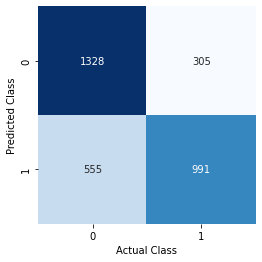

In [95]:
matrix_confusion = confusion_matrix([np.argmax(y) for y in y_test], [np.argmax(y) for y in y_pred])
cf_plot = sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
cf_plot.set(xlabel='Actual Class', ylabel='Predicted Class')

In [102]:
new_tweet = 'Covid is very very bad news in this era'
tweet_clean = clean_text(new_tweet)
tweet_tokens = tokenize([tweet_clean])
tweet_vector = vectorize(tweet_tokens)
tweet_pad = padding_sequence(tweet_vector, MAX_SEQUENCE_LENGTH)
tweet = np.array(tweet_pad)
predicted = model.predict(tweet)
if np.argmax(predicted) == 0:
  print(new_tweet, ' -> Negative', round(predicted[0][0], 2))
else:
  print(new_tweet, ' -> Positive', round(predicted[0][1], 2))


Word failed to vectorize : []
Covid is very very bad news in this era  -> Negative 0.75
